# Variable Ranking Notebook

This notebook illustrates the use of variable ranking to perform feature selection on the SRBC dataset. The performance of a nearest neighbor classifier will be reported as a function of the number of variables considered. We will compare results with a base-line that selects features at random.

First, we load the required packages.

In [11]:
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import sys

## Loading the Data

We load the data from a CSV file using pandas. The dataset considered is 'Simple Round Blue Cell Tumors' (SRBCT) dataset from the reference: Khan, J., Wei, J. S., Ringnér, M., Saal, L. H., Ladanyi, M., Westermann, F., … Meltzer, P. S. (2001). Classification and diagnostic prediction of cancers using gene expression profiling and artificial neural networks. Nature Medicine, 7(6), 673–679. http://doi.org/10.1038/89044. This dataset has a training and a testing set, each containing 64 and 20 instances, respectively. The number of attributes is 2308, corresponding to different gene expression profiles. The number of classes is 4, corresponding to different tumors:  neuroblastoma (NB), rhabdomyosarcoma (RMS), non-Hodgkin lymphoma (NHL) and the Ewing family of tumors (EWS).

In [12]:
dataTrain = pd.read_csv('srbct_train.csv')
X_train = dataTrain.values[ :, 0 : (dataTrain.shape[ 1 ] - 1) ].astype(float)
y_train = (dataTrain.values[ :, dataTrain.shape[ 1 ] - 1 ]).astype(int)

dataTest = pd.read_csv('srbct_test.csv')
X_test = dataTest.values[ :, 0 : (dataTest.shape[ 1 ] - 1) ].astype(float)
y_test = (dataTest.values[ :, dataTest.shape[ 1 ] - 1 ]).astype(int)


In [13]:
print(X_train.shape)
print(X_test.shape)

(64, 2308)
(20, 2308)


We merge the train and the test data to get a single data set of 84 instances.

In [14]:
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

## Classifiers and Objects to Preprocess the Data

We create a standard scaler and a KNN classifier. The number of neighbors to be used will be equal to the default value (i.e. 5). We will use a standard scale to preprocess the data. 

In [15]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

## Cross Validation Process to Estimate the Generalization Performance

We carry out a 10-fold cross validation process to estimate the prediction performance of the KNN classifier as a function of the number of features considered.

In [16]:
# This is the number of times the 10-fold cv process will be repeated

n_repeats = 1

In [17]:
rkf = RepeatedKFold(n_splits=10, n_repeats = n_repeats, random_state=0)

We set n_features to contain the number of features tested. We consider an exponentially increasing number of features. So that we can have many small sets of large features evaluated and only a few large ones.

In [18]:
n_features = np.unique(np.round(np.exp(np.arange(0, np.log(100), 0.1))).astype(int))
print(n_features)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 18 20 22 25 27 30 33 37 40
 45 49 55 60 67 74 81 90 99]


We create an array to store the results.

In [19]:
errors_knn = np.zeros((10 * n_repeats, len(n_features)))
errors_knn_random = np.zeros((10 * n_repeats, len(n_features)))

We no do the loop over the data partitions.

In [20]:
split = 0

for train_index, test_index in rkf.split(X, y):

    # We print a dot for each train / test partition
    
    sys.stdout.write('.')
    sys.stdout.flush()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # We standardize the data

    scaler.fit(X_train, y_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # This random array will be used to pick up features at random as a base-line
    # to compare with.
    
    random_features = np.random.permutation(X.shape[ 1 ])

    # For we loop over the number of features to be tested 
    
    for i in range(len(n_features)):
        
        # We create a filter to select the required number of features
        # The filter will be based on the F-statistc "f_classif".

        filtering = SelectKBest(f_classif, k = n_features[ len(n_features) - i - 1 ])
        filtering.fit(X_train, y_train)
        
        # We carry out the feature selection process
        
        X_train_sel = filtering.transform(X_train)
        X_test_sel = filtering.transform(X_test)

        # We fit the classifier on the training data and evaluate its performance on
        # test data.

        knn.fit(X_train_sel, y_train)
        
        errors_knn[ split, len(n_features) - i - 1 ] = 1.0 - np.mean(knn.predict(X_test_sel) == y_test)

        knn.fit(X_train[ :, random_features[ 0 : n_features[ len(n_features) - i - 1 ] ] ], y_train)

        errors_knn_random[ split, len(n_features) - i - 1 ] = 1.0 - \
            np.mean(knn.predict(X_test[ :, random_features[ 0 : \
            n_features[ len(n_features) - i - 1 ] ] ]) == y_test)
        
        
    split += 1


..........

In [21]:
np.mean(errors_knn_random, 0)


array([0.59722222, 0.52361111, 0.55277778, 0.56666667, 0.53333333,
       0.50972222, 0.49444444, 0.49444444, 0.47361111, 0.4375    ,
       0.39861111, 0.41527778, 0.46111111, 0.41527778, 0.34583333,
       0.37638889, 0.36666667, 0.37638889, 0.37777778, 0.29444444,
       0.30833333, 0.29583333, 0.28611111, 0.30694444, 0.27222222,
       0.2875    , 0.22361111, 0.225     , 0.2125    , 0.23888889,
       0.23888889, 0.22916667, 0.19166667])

## Reporting the Results Obtained

We compute the performance of the classifier as a function of the number of features considered.

In [22]:
# We compute mean errors and the corresponding standard deviations

error = np.mean(errors_knn, 0)
error_std = np.std(errors_knn, 0) / np.sqrt(errors_knn.shape[ 0 ])

error_random = np.mean(errors_knn_random, 0)
error_random_std = np.std(errors_knn_random, 0) / np.sqrt(errors_knn_random.shape[ 0 ])

We generate a figure to show the reuslts obtained.

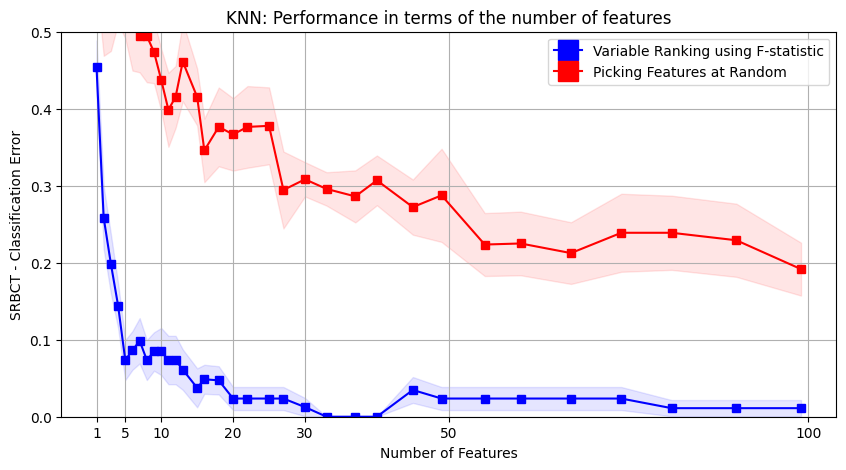

In [23]:
# The axis legend will consdier a subset of the features tested

sel = np.arange(1, len(n_features) + 1, 8) - 1

plt.figure(figsize=(10,5))
line1, = plt.plot(n_features, error, 's-', color="b")
line2, = plt.plot(n_features, error_random, 's-', color="r")
plt.fill_between(n_features, error - error_std, error + error_std, alpha=0.1, color="b")
plt.fill_between(n_features, error_random - error_random_std, \
    error_random + error_random_std, alpha=0.1, color="r")
plt.grid()
plt.title("KNN: Performance in terms of the number of features")
plt.xlabel('Number of Features')
#plt.xticks(np.array(n_features[ sel ]))
plt.xticks(np.array([1, 5, 10, 20, 30, 50, 100]))
plt.ylabel('SRBCT - Classification Error')
plt.ylim(0.0,  0.5)
legend_handles = [ mlines.Line2D([], [], color='b', marker='s', \
    markersize=15, label='Variable Ranking using F-statistic'),
    mlines.Line2D([], [], color='r', marker='s', \
    markersize=15, label='Picking Features at Random') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()


We observe that the error is low in general. However, after selecting less than 30 features, it starts increasing. This feature selection approach based on variable ranking is able to obtain a performance that is well below the random picking approach. Picking features at random works much worse than variable ranking.